In [1]:
import os, sys
import numpy as np
import geopandas as gpd
import pandas as pd
sys.path.append('../OnStove')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from onstove import OnStove, DataProcessor, RasterLayer, VectorLayer, Technology
import time

# Setup
## Choose the scenario to run
Choose betwee `Social`, `Private_low_lpg`, `Private` and `Subsidies`.

In [4]:
scenario = 'Subsidies'
exchange_rate = 123.9838 # NPR/USD

## Go to the relevant step to run
1. [Model preparation](#Model-preparation)
2. [Model run](#Model-run)
3. [Plotting and saving maps](#Plotting-and-saving-maps)

# Model preparation

## 1. Create an OnSSTOVE model

In [5]:
start = time.time()

nepal = OnStove(project_crs=3857)
output_directory = '../5. Results'
nepal.output_directory = output_directory
# nepal.energy_per_meal = 1.58 / 2 * 0.85 * 3.6

## 2. Read the model data

In [6]:
path = os.path.join('..', '3. OnStove inputs', scenario, 'Nepal_soc.csv')
nepal.read_scenario_data(path, delimiter=',')

## 3. Add a country mask layer

In [7]:
path = os.path.join(output_directory, 'Administrative', 'Country_boundaries', 'Country_boundaries.geojson')
mask_layer = VectorLayer('admin', 'adm_0', path=path)
nepal.mask_layer = mask_layer

## 4. Add a population base layer

In [8]:
path = os.path.join(output_directory, 'Demographics', 'Population', 'Population.tif')
nepal.add_layer(category='Demographics', name='Population', path=path, layer_type='raster', base_layer=True)
nepal.population_to_dataframe()

## 5. Calibrate population and urban/rural split

In [9]:
ghs_path = os.path.join(output_directory, 'Demographics', 'Urban_rural_divide', 'Urban_rural_divide.tif')
nepal.calibrate_urban_rural_split(ghs_path)

## 6. Add wealth index GIS data

In [10]:
wealth_index = r"..\2. Data\Demand\Wealth Index\npl_relative_wealth_index.csv"
nepal.extract_wealth_index(wealth_index, file_type="csv")

## 7. Calculate value of time

In [11]:
# Based on wealth index, minimum wage and a lower an upper range for cost of oportunity
nepal.get_value_of_time()

## 8. Read electricity network GIS layers

In [12]:
# Read MV lines
path = os.path.join(output_directory, 'Electricity', 'MV_lines', 'MV_lines.geojson')
mv_lines = VectorLayer('Electricity', 'MV_lines', path=path)

# Read MG
path = os.path.join(output_directory, 'Electricity', 'MG_access', 'MG_access.geojson')
mg_access = VectorLayer('Electricity', 'MG_access', path=path)

### 8.1. Calculate distance to electricity infrastructure 

In [13]:
nepal.distance_to_electricity(mv_lines=mv_lines)

### 8.2. Add night time lights data

In [14]:
path = os.path.join(output_directory, 'Electricity', 'Night_time_lights', 'Night_time_lights.tif')
ntl = RasterLayer('Electricity', 'Night_time_lights', path=path)

nepal.raster_to_dataframe(ntl, name='Night_lights', method='read')

## 9. Calibrate current electrified population

In [15]:
nepal.current_elec()
nepal.final_elec()

print('Calibrated grid electrified population fraction:', nepal.gdf['Elec_pop_calib'].sum() / nepal.gdf['Calibrated_pop'].sum())

Calibrated grid electrified population fraction: 0.7188219585875895


## 10. Read the cooking technologies data

In [16]:
path = os.path.join('..', '3. OnStove inputs', scenario, 'Nepal_tech.csv')
nepal.read_tech_data(path, delimiter=',')

## 11. Adding Electric cooking data

### 11.1. Mini grids coverage and ecooking potential

In [17]:
mg_dist_path = os.path.join(output_directory, 'Electricity', 'MG_points', 'MG_points_dist.tif')
mg_access_path = os.path.join(output_directory, 'Electricity', 'MG_access', 'MG_access.geojson')
ntl_path = os.path.join(output_directory, 'Electricity', 'Night_time_lights', 'Night_time_lights.tif')

nepal.techs['Mini_Grids'].distance = mg_dist_path
nepal.techs['Mini_Grids'].coverage = mg_access_path
nepal.techs['Mini_Grids'].ntl = ntl_path

### 11.1. Adding percentage of households that need to upgrade connection and electricity cost 

In [18]:
breaker_upgrade = VectorLayer(path=r"..\2. Data\Breaker size & monthly elec cost GDF\province_breakersize.geojson")

In [19]:
def get_tariff(row, energy):
    breaker = (electricity_tariffs['Breaker size (Amp)'] == row['variable'])
    demand = energy / (3.6 * 12)
    demand_level = electricity_tariffs.loc[electricity_tariffs['kWh (Monthly)'] >= demand, 'kWh (Monthly)'].min()
    demand_rows = (electricity_tariffs['kWh (Monthly)'] == demand_level)
    dff = electricity_tariffs.loc[breaker & demand_rows]
    return (float(dff['Monthly Minimum Charge (Nrs.)']) / demand + float(dff['Energy Charge (Nrs./kWh)'])) / exchange_rate

if scenario in ['Private', 'Private_low_lpg', 'Subsidies']: 
    electricity_tariffs = pd.read_csv(r"..\2. Data\Breaker size & monthly elec cost GDF\electricity_tariffs.csv")
    breaker_upgrade.data.rename(columns={'5(Amps)': 5, '6-15(Amps)': 15, '16-30(Amps)': 30, '31-60(Amps)': 60}, inplace=True)
    breaker_melted = breaker_upgrade.data.melt(id_vars=['Province'],
                                               value_vars=[5, 15, 30, 60])
    breaker_melted.loc[breaker_melted['variable']==5, 'variable'] = 15

    nepal.techs['Electricity'].required_energy(nepal)
    breaker_melted['elec_cost'] = breaker_melted.apply(lambda row: get_tariff(row, nepal.techs['Electricity'].energy), axis=1)
    
    for province in breaker_melted['Province'].unique():
        dff = breaker_melted.loc[breaker_melted['Province'] == province, ['elec_cost', 'value']]
        cost = sum(dff['value'] * dff['elec_cost']) / dff['value'].sum()
        breaker_upgrade.data.loc[breaker_upgrade.data['Province']==province, 'elec_cost'] = cost    

C:\Users\camilorg\AppData\Local\Temp\ipykernel_24220\3960542548.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


In [20]:
elec_data = nepal.gdf[['Households', 'geometry']].sjoin(breaker_upgrade.data[['%_households_upgrade', 'elec_cost', 'geometry']], how='left')

In [21]:
if scenario in ['Private', 'Private_low_lpg', 'Subsidies']: 
    nepal.techs['Electricity'].fuel_cost = elec_data['elec_cost']
    nepal.techs['Mini_Grids'].fuel_cost = elec_data['elec_cost']
nepal.techs['Electricity'].connection_cost *= elec_data['%_households_upgrade']

### 11.2. Calculating grid added capacity cost

In [22]:
nepal.techs['Electricity'].get_capacity_cost(nepal)

## 12. Reading GIS data for LPG supply

In [23]:
lpg = RasterLayer('LPG', 'LPG Traveltime', 
                  os.path.join(output_directory, 'LPG', 'LPG Traveltime', 'LPG Traveltime.tif'))
nepal.techs['LPG'].travel_time = nepal.raster_to_dataframe(lpg,
                                                           fill_nodata_method='interpolate', 
                                                           method='read') * 2 / 60

## 13. Adding GIS data for Traditional and Improved Biomass

In [24]:
nepal.techs['Traditional_Biomass'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Traditional_Biomass'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')
nepal.techs['Traditional_Biomass'].forest_condition = lambda x: x > 30

nepal.techs['Biomass_ICS_T2'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Biomass_ICS_T2'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')
nepal.techs['Biomass_ICS_T2'].forest_condition = lambda x: x > 30

nepal.techs['Biomass_ICS_T3'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Biomass_ICS_T3'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')
nepal.techs['Biomass_ICS_T3'].forest_condition = lambda x: x > 30

## 14. Adding GIS data for Biogas

In [25]:
admin = gpd.read_file(r"../2. Data\Other\Administrative boundaries\Admin lvl 0.shp")
buffaloes = os.path.join(output_directory, 'Biogas', 'Livestock', 'buffaloes', 'buffaloes.tif')
cattles = os.path.join(output_directory, 'Biogas', 'Livestock', 'cattles', 'cattles.tif')
poultry =os.path.join(output_directory, 'Biogas', 'Livestock', 'poultry', 'poultry.tif')
goats = os.path.join(output_directory, 'Biogas', 'Livestock', 'goats', 'goats.tif')
pigs = os.path.join(output_directory, 'Biogas', 'Livestock', 'pigs', 'pigs.tif')
sheeps = os.path.join(output_directory, 'Biogas', 'Livestock', 'sheeps', 'sheeps.tif')

# nepal.techs['Biogas'].water = r"..\Clean cooking Africa paper\01. Data\GIS-data\Water scarcity\y2019m07d11_aqueduct30_annual_v01.gpkg"
nepal.techs['Biogas'].temperature = os.path.join(output_directory, 'Biogas', 'Temperature', 'Temperature.tif')
nepal.techs['Biogas'].recalibrate_livestock(nepal, buffaloes, cattles, poultry, goats, pigs, sheeps)
nepal.techs['Biogas'].friction_path = os.path.join(nepal.output_directory, 'Biomass', 'Friction', 'Friction.tif')

## 15. Saving the prepared model inputs

In [26]:
os.makedirs(os.path.join(nepal.output_directory, scenario), exist_ok=True)
nepal.to_pickle(f"{scenario}/model.pkl")

In [27]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 1 min 26 sec


[Get back to setup](#Setup)

# Model run

## 1. Read the OnSSTOVE model

In [5]:
start = time.time()
folder = '../5. Results'
nepal = OnStove.read_model(f"{folder}/{scenario}/model.pkl")

In [6]:
nepal.output_directory = os.path.join(folder, scenario)

## 2. Adding subsidies

### 2.1. Biomass ICS Tier 3 stoves
According to the [Renewable Energy Subsidy Policy 2022](https://www.aepc.gov.np/uploads/docs/uu-a-1648949209.pdf) subsidies will be given to:
>50% subsidy for one or two pot hole with full or partial metal body rocket (not to exceed Rs. 3,000) & gasifier stoves (not to exceed Rs. 4,000) in rural and peri-urban areas

In [7]:
if scenario in ['Subsidies', 'Private', 'Private_low_lpg']:
    nepal.techs['Biomass_ICS_T3'].inv_cost = pd.Series(nepal.techs['Biomass_ICS_T3'].inv_cost * np.ones(nepal.gdf.shape[0]), 
                                                       index=nepal.gdf.index)
    nepal.techs['Biomass_ICS_T3'].inv_cost.loc[(nepal.gdf['IsUrban'] < 20)] *= 0.5

### 2.2. Biogas digester investments
According to the [Renewable Energy Subsidy Policy 2022](https://www.aepc.gov.np/uploads/docs/uu-a-1648949209.pdf), subsidies will be provided for the investments in biodigesters depending on their size and ecological zone:
Region|2 cubic meters|4 cubic meters|6 cubic meters and above|Average (Rs)|Average (USD)
:---|---:|---:|---:|---:|---:
Mountain districts|32,500|39,000|45,500|39,000|314
Hill districts|26,000|32,500|39,000|32,500|262
Terai districts|19,200|24,000|28,800|24,000|193

We use the average subsidie per ecological zone.

In [8]:
if scenario in ['Private', 'Subsidies', 'Private_low_lpg']:
    eco_zones = VectorLayer(path=r"..\2. Data\Other\Ecological zones\Ecological zones.geojson")
    eco_zones.reproject(3857)
    zones = nepal.gdf[['Households', 'geometry']].sjoin(eco_zones.data[['zone', 'geometry']], how='left')
    nepal.gdf['eco_zone'] = zones['zone']
    nepal.techs['Biogas'].inv_cost = pd.Series(nepal.techs['Biogas'].inv_cost * np.ones(nepal.gdf.shape[0]), 
                                               index=nepal.gdf.index)
    nepal.techs['Biogas'].inv_cost.loc[(nepal.gdf['eco_zone']=='Terai')] -= 193.5736766
    nepal.techs['Biogas'].inv_cost.loc[(nepal.gdf['eco_zone']=='Hills')] -= 262.1310203
    nepal.techs['Biogas'].inv_cost.loc[(nepal.gdf['eco_zone']=='Mountain')] -= 314.5572244

### 2.3. Moving fuel subsidies from LPG to Electricity
Currently the Nepal Oil Corporation says it buys LPG at Rs2,551.15 per cylinder and sells it for Rs1,800 incurring on a loss of Rs751.14 on every cylinder sold: https://kathmandupost.com/national/2022/06/07/oil-utility-mulls-reviving-dual-pricing-on-cooking-gas-insiders-sceptical 

We take the sell price and reduce the subsidy while we increase the subsidy for Electricity, until the same subsidy is reached in terms of cost/energy unit. 

In [9]:
if scenario in ['Subsidies']:
    increment_percentage = 1 # in percentage of subsidy
    increment = 549.875 * increment_percentage / (exchange_rate * 14.2) # USD per kg
    nepal.techs['LPG'].fuel_cost += increment
    
    increment_per_MJ = increment / nepal.techs['LPG'].energy_content # in USD/MJ
    decrease_per_kwh = increment_per_MJ * nepal.techs['Electricity'].energy_content # in USD/kWh

    el_sub_factor = 0.5
    nepal.techs['Electricity'].fuel_cost -= decrease_per_kwh * el_sub_factor
    nepal.techs['Mini_Grids'].fuel_cost -= decrease_per_kwh * el_sub_factor

## 3. Calculating benefits and costs of each technology and getting the max benefit technology for each cell

In [33]:
base_techs = {}
for name, tech in nepal.techs.items():
    if (tech.current_share_urban > 0) or (tech.current_share_rural > 0):
        base_techs[name] = tech

In [34]:
base_fuel = Technology(name='Base fuel')
base_fuel.carbon = 0
base_fuel.total_time_yr = 0

for name, tech in base_techs.items():
    cooking_shares = RasterLayer(path=f'../5. Results/Demographics/Cooking/{name}/{name}.tif')
    data = pd.Series(nepal.raster_to_dataframe(cooking_shares, method='read', fill_nodata_method='nearest'), 
                     index=nepal.gdf.index)
    tech.pop_sqkm = data

base_fuels = {}
for tech in list(nepal.techs.values()):
    share = tech.current_share_rural + tech.current_share_urban
    if (share >= 0) or tech.is_base:
        tech.is_base = True
        base_fuels[tech.name] = tech
nepal.get_clean_cooking_access(base_fuels=base_fuels)

for name, tech in base_techs.items():    
    tech.carb(nepal)
    tech.total_time(nepal)
    tech.required_energy(nepal)

    if name == 'LPG':
        tech.transportation_cost(nepal)

    tech.discounted_inv(nepal, relative=False)
    base_fuel.tech_life += tech.tech_life * tech.pop_sqkm
    base_fuel.discounted_investments += tech.discounted_investments * tech.pop_sqkm

    tech.adjusted_pm25()
    tech.health_parameters(nepal)

    base_fuel.carbon += tech.carbon * tech.pop_sqkm
    base_fuel.total_time_yr += (tech.total_time_yr * tech.pop_sqkm).fillna(0)
    base_fuel.inv_cost += tech.inv_cost * tech.pop_sqkm
    base_fuel.om_cost += tech.om_cost * tech.pop_sqkm

    tech.discount_fuel_cost(nepal, relative=False)
    base_fuel.discounted_fuel_cost += tech.discounted_fuel_cost * tech.pop_sqkm

    for paf in ['paf_alri', 'paf_copd', 'paf_ihd',
                'paf_lc', 'paf_stroke']:
        base_fuel[paf] += tech[paf] * tech.pop_sqkm

nepal.base_fuel = base_fuel

AttributeError: 'MiniGrids' object has no attribute 'pop_sqkm'

In [41]:
names = ['Electricity', 'Mini_Grids', 'LPG', 'Biogas', 'Traditional_Biomass', 'Biomass_ICS_T2', 'Biomass_ICS_T3']
nepal.run(technologies=names)

[Nepal] Calculating clean cooking access
[Nepal] Getting value of time
[Nepal] Calculating base fuel properties

The sum of rural technology shares you provided in the tech specs does not equal 1.0.
The shares have been adjusted to make the sum 1.0 as follows.
If you are not satisfied then please adjust the shares to your liking manually in the tech specs file:
      - Biogas 1.150 %
      - Biomass_ICS_T2 16.783 %
      - Biomass_ICS_T3 1.259 %
      - Electricity 0.377 %
      - LPG 19.834 %
      - Traditional_Biomass 60.598 %


The sum of urban technology shares you provided in the tech specs does not equal 1.0.
The shares have been adjusted to make the sum 1.0 as follows.
If you are not satisfied then please adjust the shares to your liking manually in the tech specs file:
      - Biogas 1.244 %
      - Biomass_ICS_T2 16.364 %
      - Biomass_ICS_T3 1.227 %
      - Electricity 0.565 %
      - LPG 57.978 %
      - Traditional_Biomass 22.621 %

Calculating health benefits for Electr

## 4. Printing the results

In [42]:
nepal.summary()

,Max benefit technology,Population (Million),Households (Millions),Total net benefit (MUSD),Total deaths avoided (pp/yr),Health costs avoided (MUSD),hours/hh.day,Opportunity cost avoided (MUSD),Reduced emissions (Mton CO2eq),Emission costs avoided (MUSD),Investment costs (MUSD),Fuel costs (MUSD),O&M costs (MUSD),Salvage value (MUSD)
0,Biogas,2.525962,0.587433,104.20493,1016.21579,111.029792,0.39701,13.784003,1.983736,101.17052,168.589449,-21.668078,1.148102,138.643465
1,Biomass_ICS_T3,1.293444,0.300801,23.699821,91.028058,9.567903,0.294232,4.72107,0.535281,27.299348,3.294804,-11.509614,0.589026,2.748737
2,Electricity,20.623772,4.67667,843.899744,8844.292046,972.446859,1.318653,414.802218,13.659176,696.617994,437.267019,74.86842,7.54585,74.276244
3,LPG,4.71344,1.094486,98.823438,1879.320562,205.339881,1.330446,87.185525,3.137614,160.018317,22.787876,160.735521,2.120433,12.623576
4,Mini_Grids,0.00796,0.001851,0.245226,4.092638,0.449282,0.879093,0.090609,0.006332,0.322911,0.216518,0.062901,0.003627,0.033633
total,total,29.164578,6.661242,1070.873159,11834.949094,1298.833717,1.192932,520.583425,19.322139,985.429091,632.155666,202.489151,11.407037,228.325656


In [155]:
nepal.summary()

,Max benefit technology,Population (Million),Households (Millions),Total net benefit (MUSD),Total deaths avoided (pp/yr),Health costs avoided (MUSD),hours/hh.day,Opportunity cost avoided (MUSD),Reduced emissions (Mton CO2eq),Emission costs avoided (MUSD),Investment costs (MUSD),Fuel costs (MUSD),O&M costs (MUSD),Salvage value (MUSD)
0,Biogas,2.515289,0.584951,103.617839,1010.649365,110.411031,0.396287,13.698931,1.975393,100.745022,167.80077,-21.577008,1.143273,137.995447
1,Biomass_ICS_T3,1.215149,0.282593,22.014629,82.777938,8.688166,0.294839,4.441064,0.502944,25.650131,3.101308,-10.829214,0.553401,2.585961
2,Electricity,20.634445,4.679152,848.5375,8893.129805,977.701655,1.318747,415.027351,13.667491,697.042024,437.530979,74.955762,7.550678,74.319461
3,LPG,4.791735,1.112694,99.590326,1904.503466,208.07201,1.329572,88.441298,3.190226,162.701505,23.173415,163.473634,2.156058,12.837019
4,Mini_Grids,0.00796,0.001851,0.244024,4.080689,0.447945,0.879093,0.090609,0.006332,0.322911,0.216518,0.062901,0.003627,0.033633
total,total,29.164578,6.661242,1074.004318,11895.141263,1305.320808,1.19599,521.699252,19.342384,986.461593,631.82299,206.086075,11.407037,227.771522


## 5. Saving the results

In [43]:
nepal.to_pickle("results.pkl")
nepal.summary().to_csv(os.path.join(nepal.output_directory, 'summary.csv'), index=False)

[Get back to setup](#Setup)

# Plotting and saving maps

## 1. Reading the results and creating the colormap

In [44]:
# scenario = 'Subsidies'
folder = '../5. Results'
nepal = OnStove.read_model(f"{folder}/{scenario}/results.pkl")

In [45]:
cmap = {"Biomass ICS T2": '#B6195E',
        "Biomass ICS T2 and Biogas": "#F6029E", 
        "Biomass ICS T3": '#57365A', 
        "Biomass ICS T3 and Biogas": "#bd57b6", 
        "Biogas": '#73af48', 
        "LPG": '#40bdbc', 
        "LPG and Biogas": "#156e5e", 
        "Electricity": '#d14a36',
        "Electricity and Biomass ICS T2": "#FF0000",
        "Electricity and Biomass ICS T3": "#e5a3a3", 
        "Electricity and Biogas": "#e17c05",
        "Electricity and LPG": "#FFC107", 
        "Electricity and Mini Grids": "#ffd9df",
        "Mini Grids": "#0096FF", #ff7678
        "Mini Grids and Biogas": "#0047AB"} #ffd9df

labels = {"Biogas and Electricity": "Electricity and Biogas",
          "Biogas and LPG": "LPG and Biogas",
          "Biogas and Biomass ICS T3": "Biomass ICS T3 and Biogas",
          "Biogas and Biomass ICS T2": "Biomass ICS T2 and Biogas",
          "Biogas and Mini Grids": "Mini Grids and Biogas"}

scale_bar_prop = dict(size=100000, style='double', textprops=dict(size=11), location=(0.5, 0.02),
                      linekw=dict(lw=1, color='black'), extent=0.01, loc='lower center')
north_arrow_prop = dict(size=30, location=(0.92, 0.92), linewidth=0.5)

In [46]:
from IPython.display import Markdown, display

def swatches(colors, sep=' ', width=1):
    display(Markdown(sep.join(
        f'<span style="color: {color}">{chr(9607)*width} <span style="font-family: monospace">{color} - <span style="font-family: monospace">{label} </span></span><br>'
        for label, color in colors.items()
    )))  
    
swatches(cmap)

<span style="color: #B6195E">▇ <span style="font-family: monospace">#B6195E - <span style="font-family: monospace">Biomass ICS T2 </span></span><br> <span style="color: #F6029E">▇ <span style="font-family: monospace">#F6029E - <span style="font-family: monospace">Biomass ICS T2 and Biogas </span></span><br> <span style="color: #57365A">▇ <span style="font-family: monospace">#57365A - <span style="font-family: monospace">Biomass ICS T3 </span></span><br> <span style="color: #bd57b6">▇ <span style="font-family: monospace">#bd57b6 - <span style="font-family: monospace">Biomass ICS T3 and Biogas </span></span><br> <span style="color: #73af48">▇ <span style="font-family: monospace">#73af48 - <span style="font-family: monospace">Biogas </span></span><br> <span style="color: #40bdbc">▇ <span style="font-family: monospace">#40bdbc - <span style="font-family: monospace">LPG </span></span><br> <span style="color: #156e5e">▇ <span style="font-family: monospace">#156e5e - <span style="font-family: monospace">LPG and Biogas </span></span><br> <span style="color: #d14a36">▇ <span style="font-family: monospace">#d14a36 - <span style="font-family: monospace">Electricity </span></span><br> <span style="color: #FF0000">▇ <span style="font-family: monospace">#FF0000 - <span style="font-family: monospace">Electricity and Biomass ICS T2 </span></span><br> <span style="color: #e5a3a3">▇ <span style="font-family: monospace">#e5a3a3 - <span style="font-family: monospace">Electricity and Biomass ICS T3 </span></span><br> <span style="color: #e17c05">▇ <span style="font-family: monospace">#e17c05 - <span style="font-family: monospace">Electricity and Biogas </span></span><br> <span style="color: #FFC107">▇ <span style="font-family: monospace">#FFC107 - <span style="font-family: monospace">Electricity and LPG </span></span><br> <span style="color: #ffd9df">▇ <span style="font-family: monospace">#ffd9df - <span style="font-family: monospace">Electricity and Mini Grids </span></span><br> <span style="color: #0096FF">▇ <span style="font-family: monospace">#0096FF - <span style="font-family: monospace">Mini Grids </span></span><br> <span style="color: #0047AB">▇ <span style="font-family: monospace">#0047AB - <span style="font-family: monospace">Mini Grids and Biogas </span></span><br>

C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 2.693877551020408 x 2.857142857142857 in image.
C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../5. Results/current_share.pdf
C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 2.4489795918367347 x 2.857142857142857 in image.
C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../5. Results/current_share.png


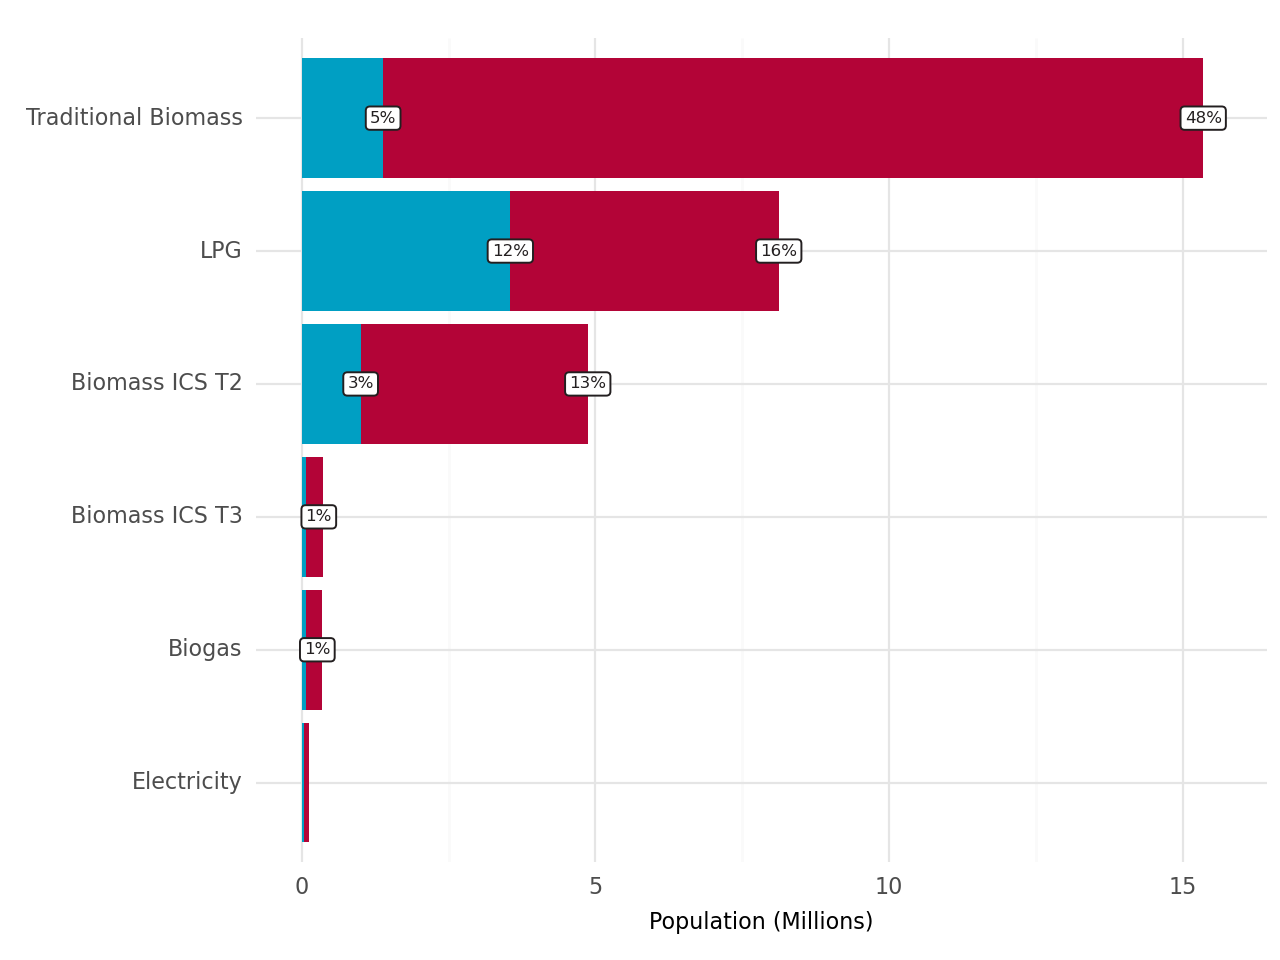

<Figure Size: (640 x 480)>

In [47]:
import matplotlib.pyplot as plt
import plotnine as p9

df = pd.DataFrame()
for tech in nepal.techs.values():
    dff = pd.DataFrame({'tech': [tech.name], 
                        'Population': [tech.current_share_urban * nepal.specs['population_start_year'] * nepal.specs['urban_start']], 
                        'region': 'Urban'})
    df = pd.concat([df, dff], ignore_index=True)
    dff = pd.DataFrame({'tech': [tech.name], 
                        'Population': [tech.current_share_rural * nepal.specs['population_start_year'] * (1 - nepal.specs['urban_start'])], 
                        'region': 'Rural'})
    df = pd.concat([df, dff], ignore_index=True)

# df['tech'] = df['tech'].str.replace('_', ' ')
nepal._re_name(df, labels, 'tech')
df = df.loc[df['Population']>0]
df['Population'] /= 1000000
df['Share'] = df['Population'] / df['Population'].sum()
shares = df.loc[df['Share']>0.005].copy()
shares['label_position'] = shares.groupby('tech')['Population'].transform('cumsum')

tech_list = df.groupby('tech')[['Population']].sum().sort_values('Population').index.tolist()
colors = {'Urban': '#009fc3', 'Rural': '#b30437'}
# colors = {'Urban': '#9bd5e7', 'Rural': '#e1a4a0'}

p = (p9.ggplot(df)
    + p9.geom_col(p9.aes(x='tech', y='Population', fill='region'))#, position='dodge')
    + p9.geom_label(shares,
                    p9.aes(x='tech', y='label_position', label='Share*100'),
                    format_string='{:.0f}%',
                    size=6,
                    color='#231f20'
                    )
    + p9.scale_x_discrete(limits=tech_list)
    + p9.ylim(0, shares['label_position'].max() * 1.02)
    + p9.scale_fill_manual(colors)
    + p9.coord_flip()
    + p9.theme_minimal()
    + p9.theme(text=p9.element_text(size=8), legend_position=(0.35, -0.12), legend_direction='horizontal')
    + p9.labs(x='', y='Population (Millions)', fill=''))

p.save('../5. Results/current_share.pdf', height=70/24.5, width=66/24.5)
p.save('../5. Results/current_share.png', height=70/24.5, width=60/24.5, dpi=300)
p

## 2. Plotting the results

In [48]:
# Calculating subsidies
## LPG
subsidy_lpg = 0
if scenario != 'Subsidies':
    subsidy_hh_lpg = nepal.techs['LPG'].energy / nepal.techs['LPG'].energy_content / 14.2 * 549.875 / exchange_rate
    subsidy_lpg = nepal.gdf.loc[nepal.gdf['max_benefit_tech'] == 'LPG', 'Households'].sum() * subsidy_hh_lpg / 1000000000

## Biomass ICS
subsidy_ics = (nepal.gdf.loc[nepal.gdf['max_benefit_tech']=='Biomass_ICS_T3', 'Households'] * nepal.techs['Biomass_ICS_T3'].inv_cost).sum() / 1000000000
if scenario == 'Social':
    subsidy_ics *= 0.5

## Biogas
eco_zones = VectorLayer(path=r"..\2. Data\Other\Ecological zones\Ecological zones.geojson")
eco_zones.reproject(3857)
zones = nepal.gdf[['Households', 'geometry']].sjoin(eco_zones.data[['zone', 'geometry']], how='left')
nepal.gdf['eco_zone'] = zones['zone']
subsidy_biogas = nepal.gdf.loc[(nepal.gdf['max_benefit_tech'] == 'Biogas') & 
                               (nepal.gdf['eco_zone'] == 'Terai'), 'Households'].sum() * 193.5736766
subsidy_biogas += nepal.gdf.loc[(nepal.gdf['max_benefit_tech'] == 'Biogas') & 
                                (nepal.gdf['eco_zone'] == 'Hills'), 'Households'].sum() * 262.1310203
subsidy_biogas += nepal.gdf.loc[(nepal.gdf['max_benefit_tech'] == 'Biogas') & 
                                (nepal.gdf['eco_zone'] == 'Mountain'), 'Households'].sum() * 314.5572244
subsidy_biogas /= 1000000000

## Electricity
subsidy_electricity = 0
if scenario in ['Subsidies']:
    increment = 549.875 / (exchange_rate * 14.2) # USD per kg
    
    increment_per_MJ = increment / nepal.techs['LPG'].energy_content # in USD/MJ
    subsidy_per_kwh = increment_per_MJ * nepal.techs['Electricity'].energy_content # in USD/kWh
    
    kwh_grid = nepal.techs['Electricity'].energy / nepal.techs['Electricity'].energy_content
    kwh_minigrid = nepal.techs['Mini_Grids'].energy / nepal.techs['Mini_Grids'].energy_content
    
    subsidy_electricity = nepal.gdf.loc[nepal.gdf['max_benefit_tech'] == 'Electricity', 'Households'].sum() * kwh_minigrid * subsidy_per_kwh * el_sub_factor
    subsidy_electricity += nepal.gdf.loc[nepal.gdf['max_benefit_tech'] == 'Mini_Grids', 'Households'].sum() * kwh_minigrid * subsidy_per_kwh * el_sub_factor
    subsidy_electricity /= 1000000000
    
all_subsidies = subsidy_lpg + subsidy_ics + subsidy_biogas + subsidy_electricity

# Calculating total system cost
summary = nepal.summary(total=True, pretty=False, variable='max_benefit_tech', remove_none=True)
total_costs = (summary.loc['total', 'investment_costs'] + summary.loc['total', 'fuel_costs'] + 
               summary.loc['total', 'om_costs'] - summary.loc['total', 'salvage_value']) / 1000

if scenario != 'Social':
    total_costs += all_subsidies

In [49]:
subsidies_df = pd.DataFrame({'LPG subsidies (BUS$)': [subsidy_lpg],
                             'Biomass ICS T3 subsidies (BUS$)': [subsidy_ics],
                             'Biogas subsidies (BUS$)': [subsidy_biogas],
                             'Electricity subsidies (BUS$)': [subsidy_electricity]},
                            index=['Subsidies prioritized'])
subsidies_df.to_csv(os.path.join(nepal.output_directory, f'{scenario}.csv'))
subsidies_df

,LPG subsidies (BUS$),Biomass ICS T3 subsidies (BUS$),Biogas subsidies (BUS$),Electricity subsidies (BUS$)
Subsidies prioritized,0,0.007069,0.146797,0.06852


<Axes: title={'left': 'Maximum benefit cooking technology | Nepal'}>

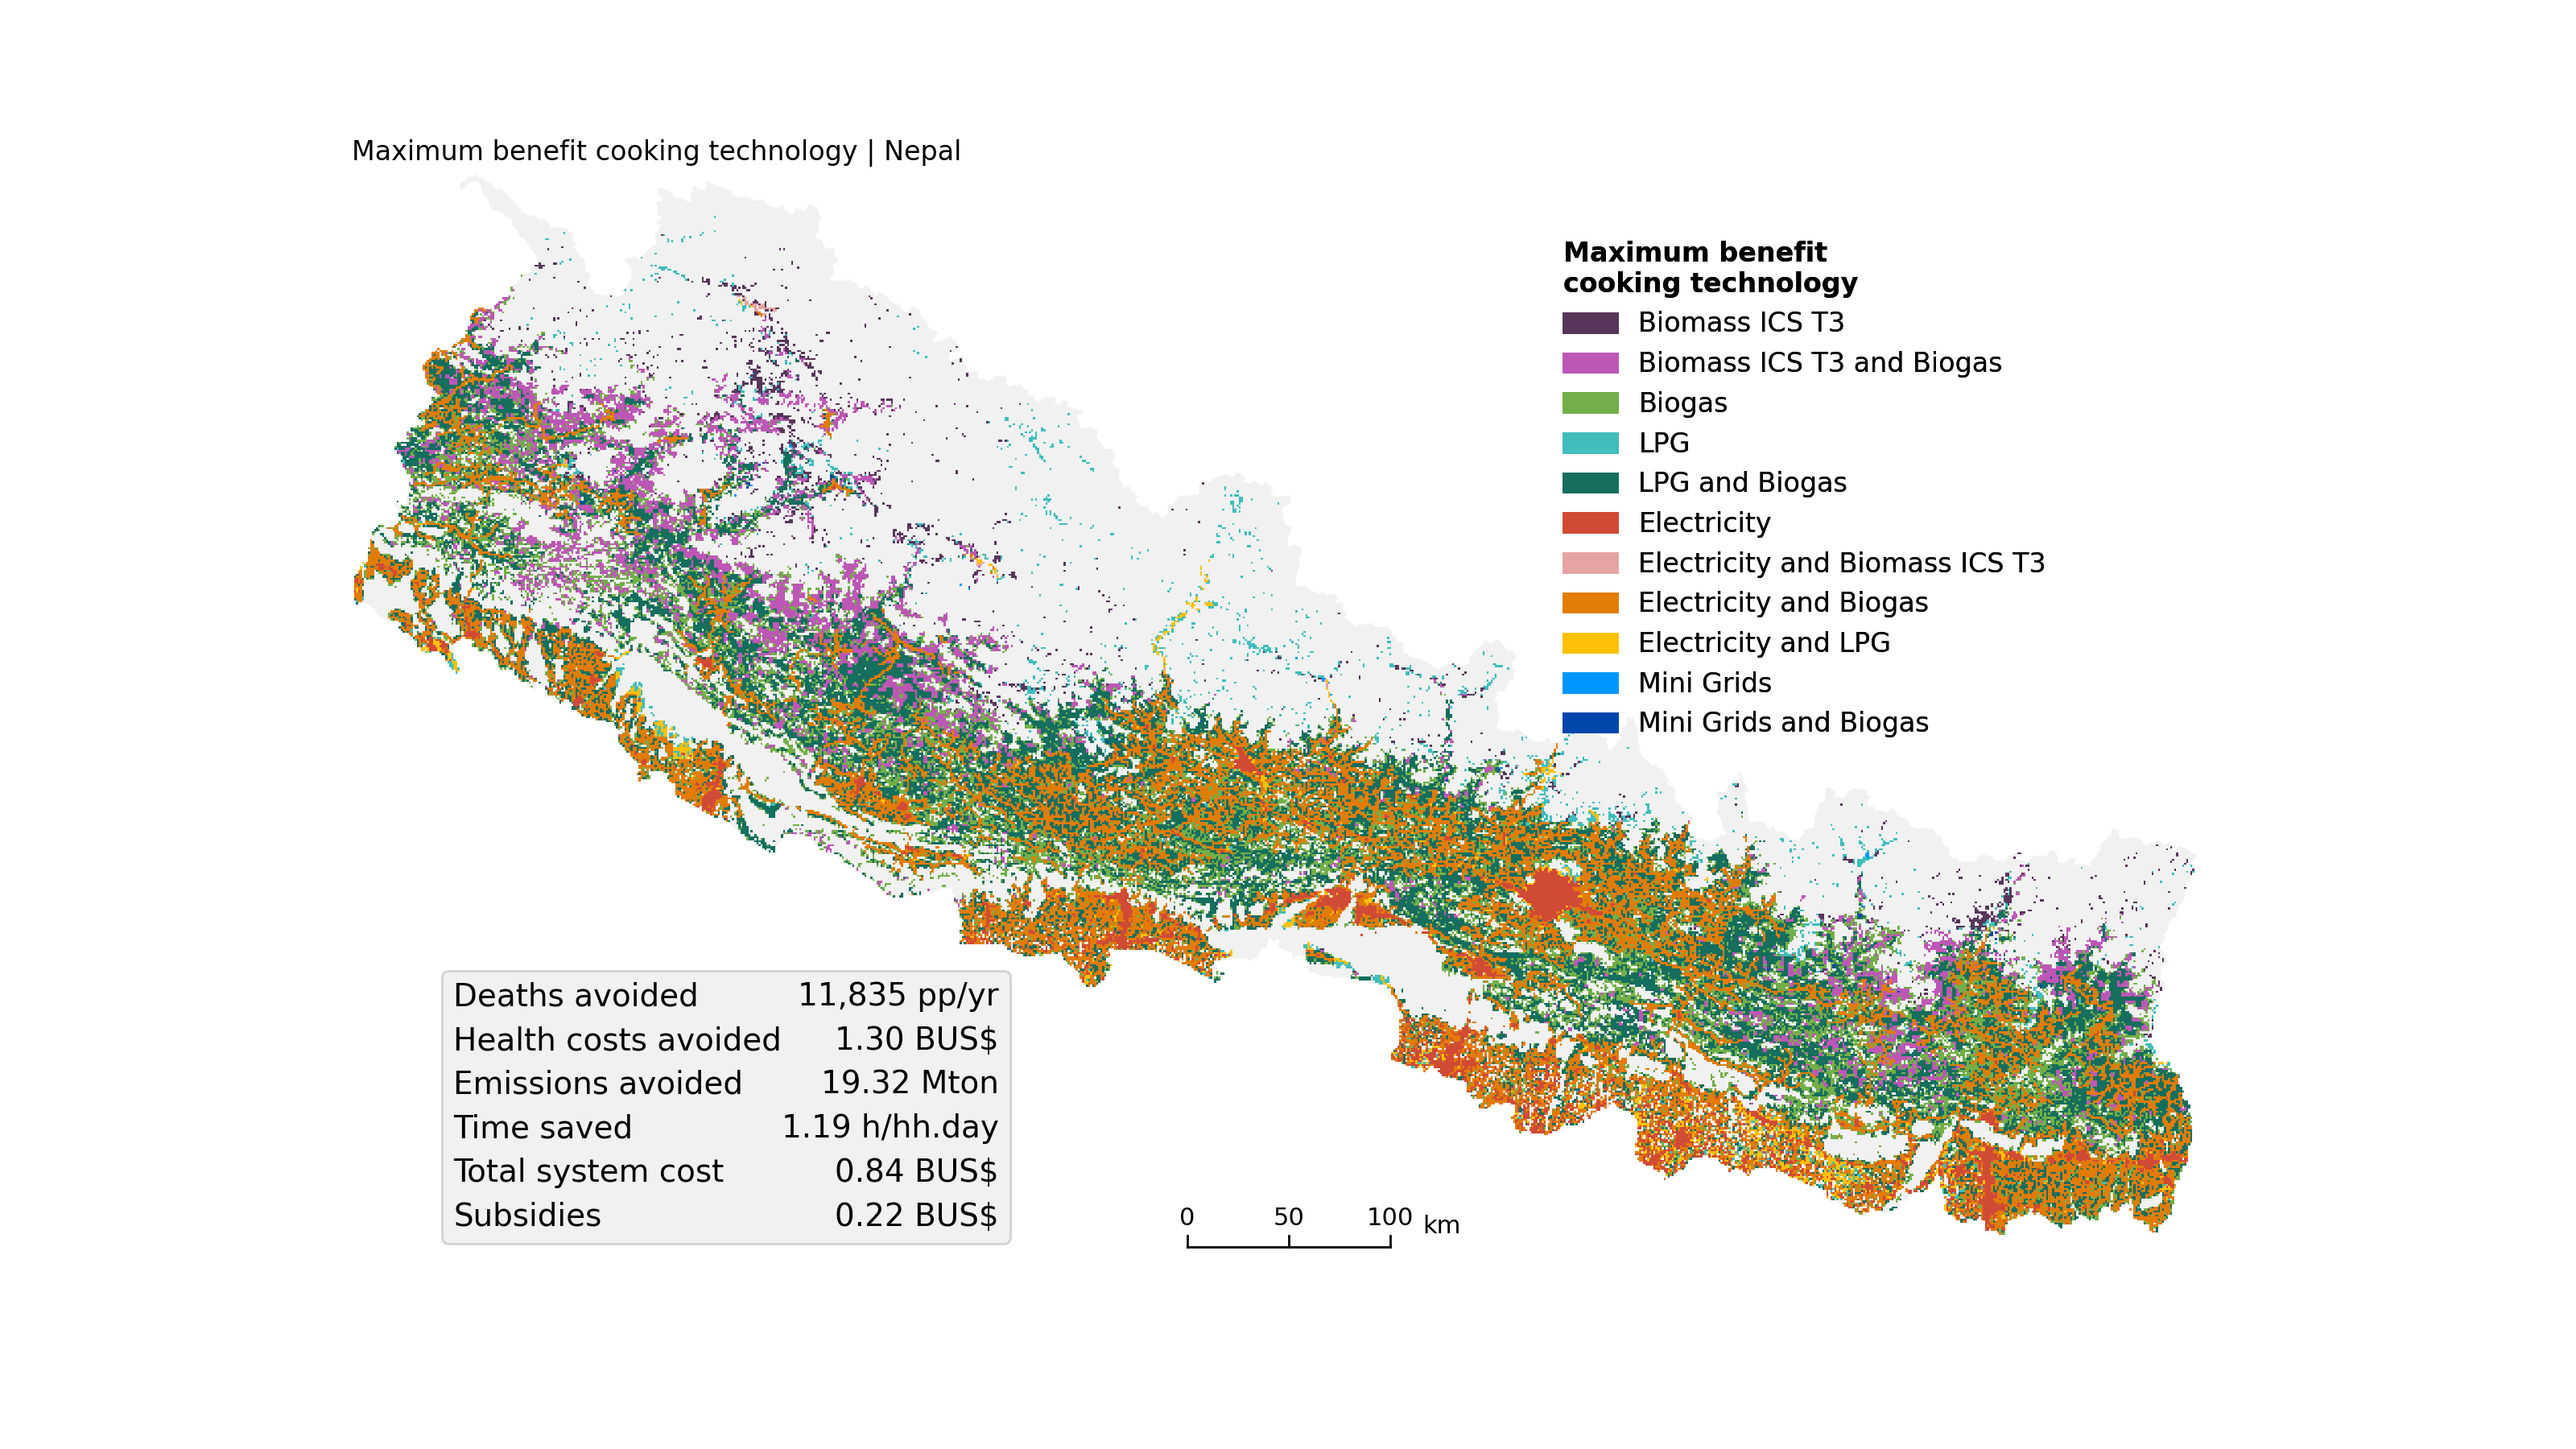

In [50]:
%matplotlib inline
nepal.plot('max_benefit_tech', cmap=cmap, legend_position=(0.62, 0.95), 
           figsize=(16,9), title=f'Maximum benefit cooking technology | Nepal',  
           labels=labels, legend=True, legend_title='Maximum benefit\ncooking technology', 
           rasterized=True, stats=True,
           stats_kwargs={'extra_stats': {'Total system cost': f'{total_costs:.2f} BUS$',
                                         'Subsidies': f'{all_subsidies:.2f} BUS$'}, 
                         'fontsize': 14, 'stats_position': (0.05, 0.28), 'pad': 2, 'sep': 0},
           scale_bar=scale_bar_prop, #north_arrow=north_arrow_prop,
           dpi=300, 
          )

<Axes: title={'left': 'Maximum benefit cooking technology | Nepal'}>

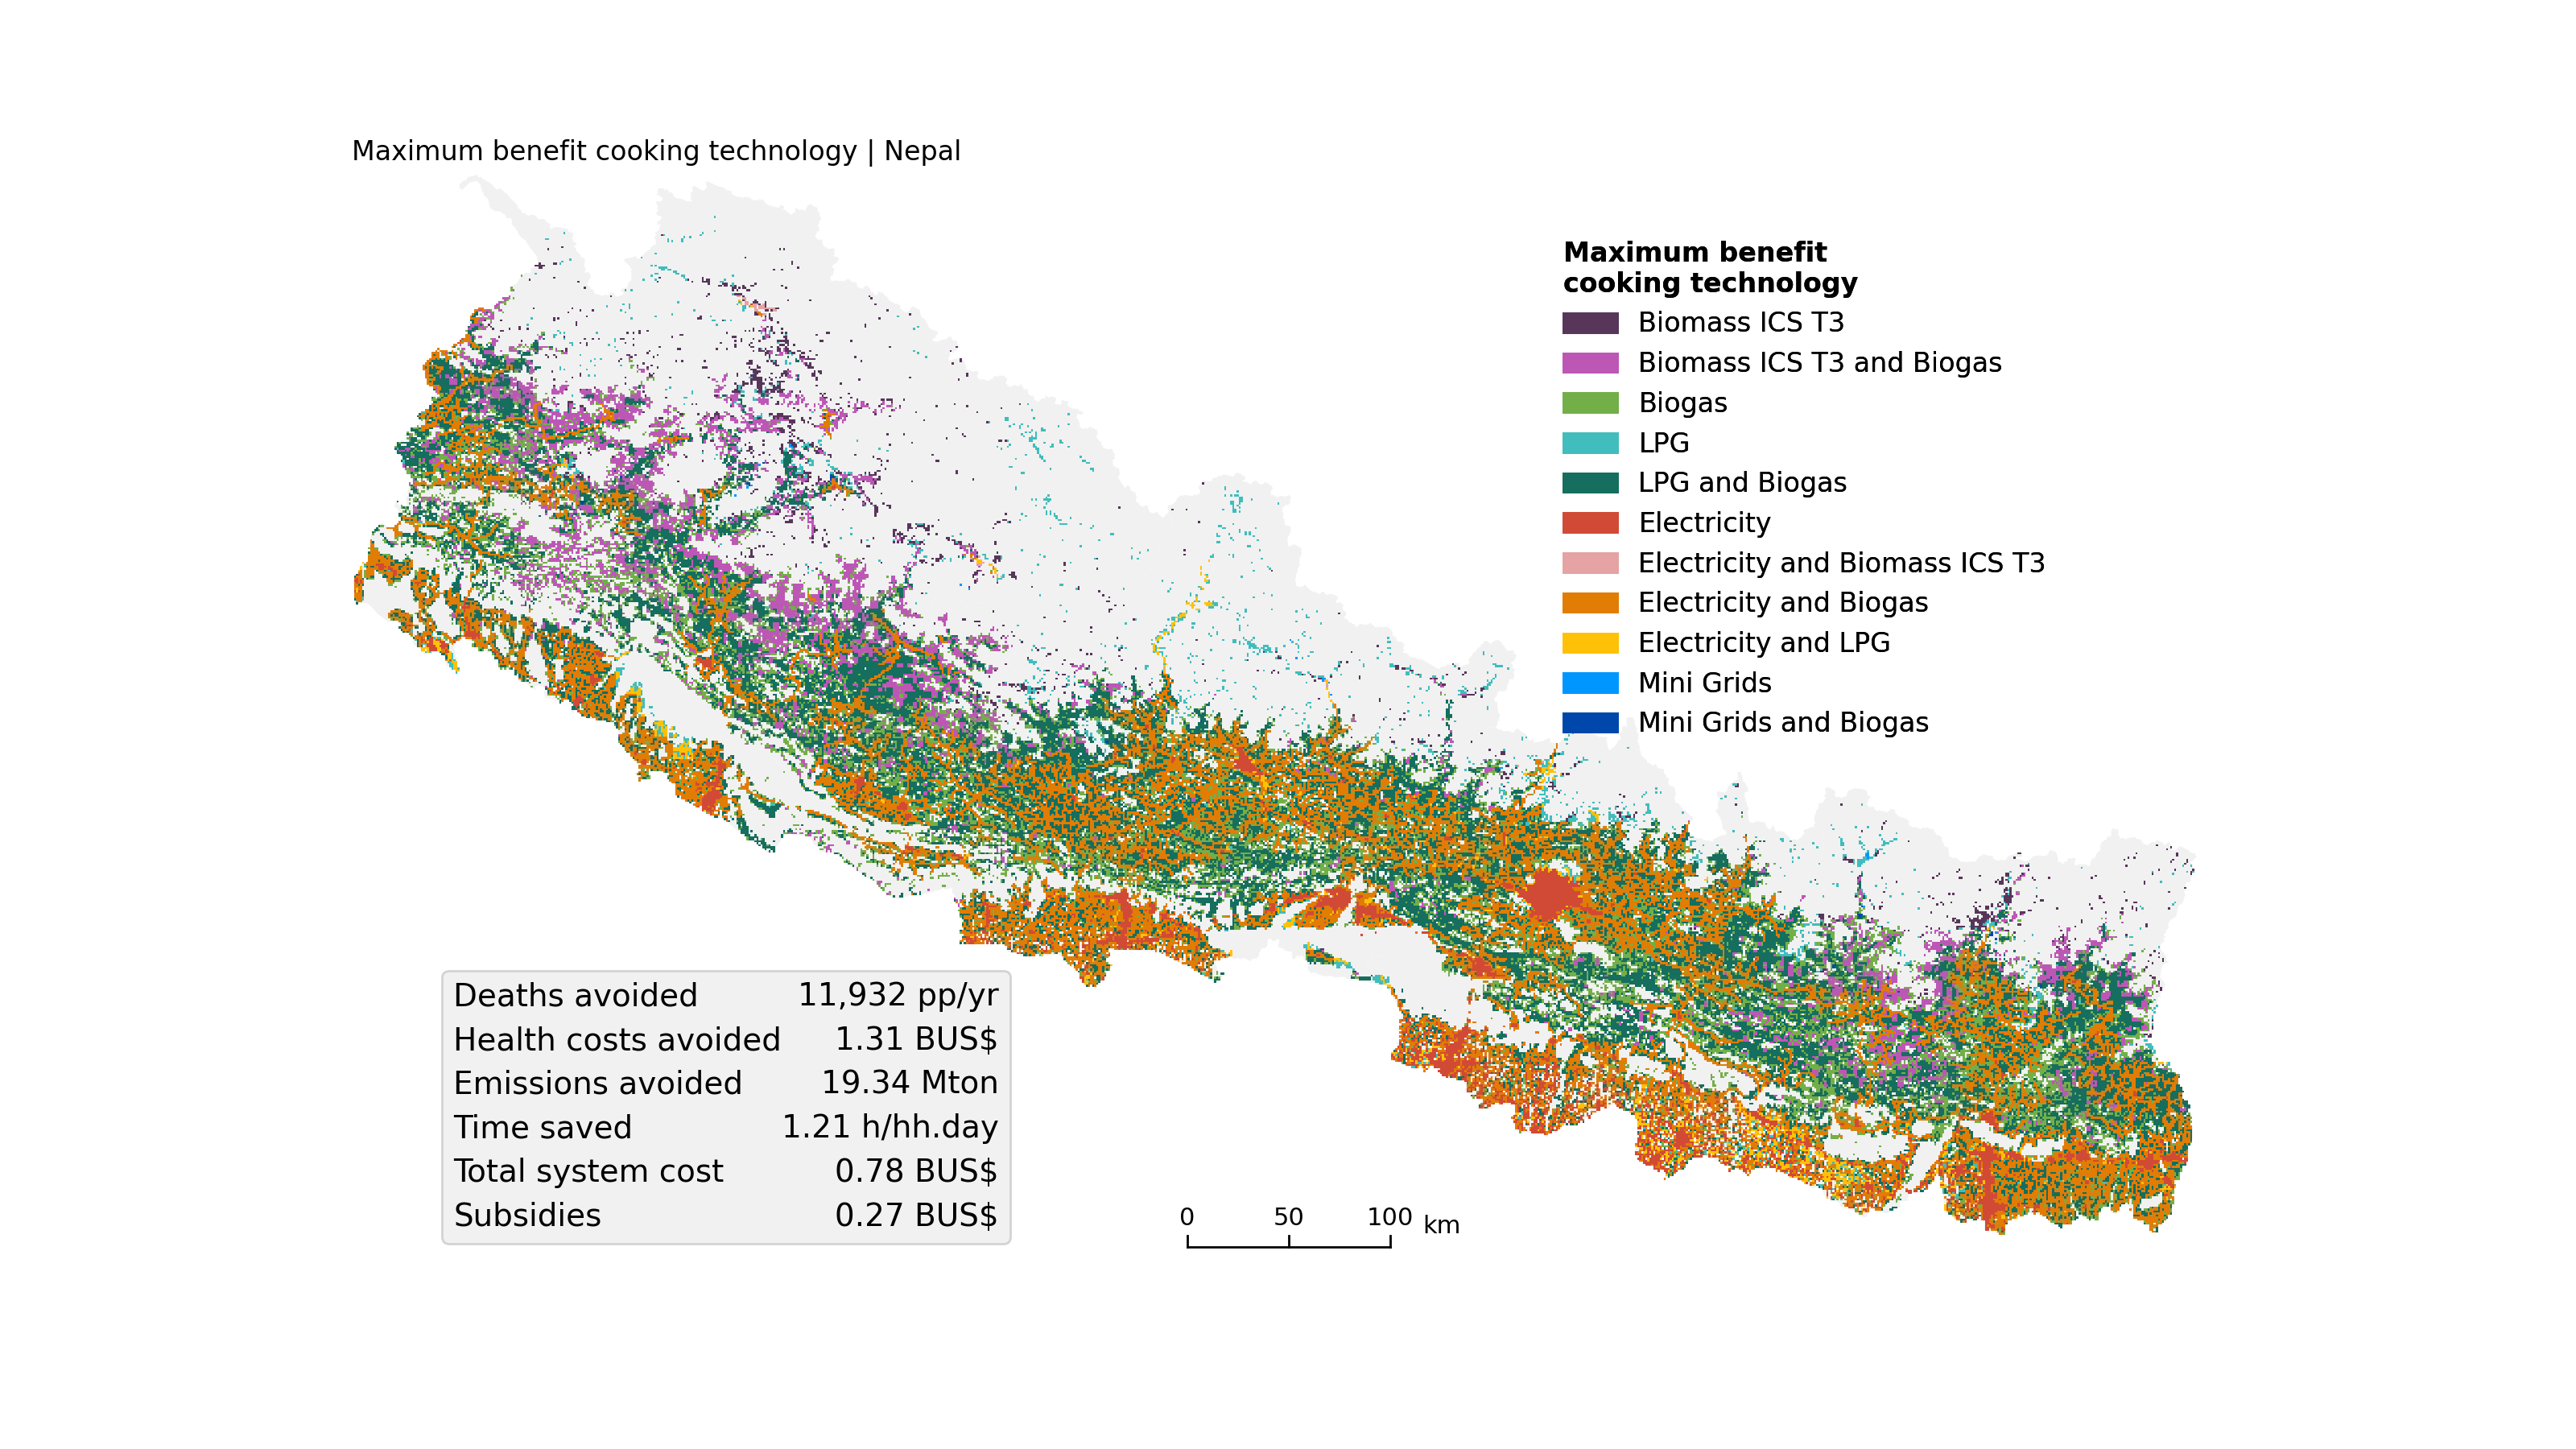

In [43]:
%matplotlib inline
nepal.plot('max_benefit_tech', cmap=cmap, legend_position=(0.62, 0.95), 
           figsize=(16,9), title=f'Maximum benefit cooking technology | Nepal',  
           labels=labels, legend=True, legend_title='Maximum benefit\ncooking technology', 
           rasterized=True, stats=True,
           stats_kwargs={'extra_stats': {'Total system cost': f'{total_costs:.2f} BUS$',
                                         'Subsidies': f'{all_subsidies:.2f} BUS$'}, 
                         'fontsize': 14, 'stats_position': (0.05, 0.28), 'pad': 2, 'sep': 0},
           scale_bar=scale_bar_prop, #north_arrow=north_arrow_prop,
           dpi=300, 
          )

In [ ]:
nepal.to_image('max_benefit_tech', cmap=cmap,
               figsize=(13, 9), dpi=300, 
               labels=labels, legend=False, legend_title='Maximum benefit\ncooking technology', 
               rasterized=True, stats=True, name='max_benefit_tech.pdf',
               stats_kwargs={'extra_stats': {'Total system cost': f'{total_costs:.2f} BUS$',
                                         'Subsidies': f'{all_subsidies:.2f} BUS$'}, 
                             'fontsize': 14, 'stats_position': (0, 0.28), 'pad': 2, 'sep': 0},
               scale_bar=scale_bar_prop, north_arrow=north_arrow_prop)

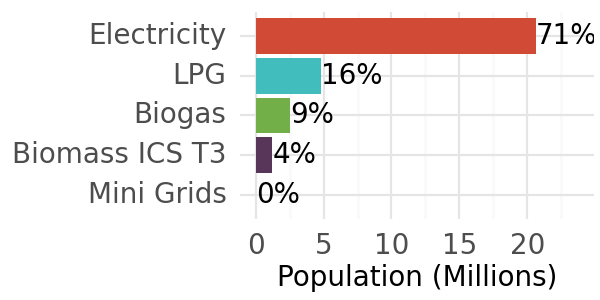

In [164]:
nepal.plot_split(cmap=cmap, labels=labels, height=1.5, width=3, orientation='h',
                 labs_kwargs=dict(x=''), save_as='tech_split_2.pdf')

In [ ]:
nepal.plot_costs_benefits(labels=labels, height=1.5, width=3, save_as='costs_benefits.pdf')

In [ ]:
from plotnine import geom_vline, annotate
from plotnine.stats.stat_boxplot import weighted_percentile
import matplotlib.pyplot as plt
import numpy as np
plt.clf()

# Draw histogram
max_val = nepal.gdf['relative_wealth'].max()
min_val = nepal.gdf['relative_wealth'].min()
binwidth = (max_val - min_val) * 0.05

fig = nepal.plot_distribution(type='histogram', variable='relative_wealth', groupby='None', cmap=cmap, labels=labels, 
                               hh_divider=1000, y_title='Households (k)', font_args=dict(color='black', size=11),
                               height=2.5, width=4, kwargs=dict(binwidth=binwidth, alpha=0.8, size=0.2), quantiles=True
                               )

# Add quantile lines
q1, q3 = weighted_percentile(a=nepal.gdf['relative_wealth'].values, q=(25, 75), weights=nepal.gdf['Households'].values)
# line1 = geom_vline(xintercept=q1, color="#4D4D4D", size=0.8, linetype="dashed")
# line3 = geom_vline(xintercept=q3, color="#4D4D4D", size=0.8, linetype="dashed")

# hist = hist + line1 + line3

# get figure to annotate
# fig = hist.draw() # get the matplotlib figure object
ax = fig.axes[0] # get the matplotlib axis (may be more than one if faceted)

# annotate quantiles
trans = ax.get_xaxis_transform()
ax.annotate('Q1', xy=(q1, 1.05), xycoords=trans,
            horizontalalignment='center',
            color='#4D4D4D', weight="bold")
ax.annotate('Q3', xy=(q3, 1.05), xycoords=trans,
            horizontalalignment='center',
            color='#4D4D4D', weight="bold")

# annotate percentages
dff = nepal.gdf.groupby('max_benefit_tech')['Households'].sum()
dff.sort_values(inplace=True)
total = dff.sum()
## Dictionaries to set the possition of the arrows and text in the histogram
y_arrow_social_private = {'Electricity': 400, 'LPG': 180, 'Biogas': 50, 'Biomass_ICS_T3': 200, 'Mini_Grids': 0}
y_arrow_low_lpg = {'Electricity': 100, 'LPG': 400, 'Biogas': 50, 'Biomass_ICS_T3': 200, 'Mini_Grids': 0}
y_arrow_subsidies = {'Electricity': 400, 'LPG': 180, 'Biogas': 50, 'Biomass_ICS_T3': 200, 'Mini_Grids': 0}
y_arrow_dict = {'Social': y_arrow_social_private, 'Private': y_arrow_social_private,
                'Private_low_lpg': y_arrow_low_lpg, 'Subsidies': y_arrow_subsidies}
y_text_subsidies = {'Electricity': 500, 'LPG': 300, 'Biogas': 250, 'Biomass_ICS_T3': 400, 'Mini_Grids': 100}
y_text_general = {'Electricity': 500, 'LPG': 500, 'Biogas': 250, 'Biomass_ICS_T3': 400, 'Mini_Grids': 100}
y_text_low_lpg = {'Electricity': 300, 'LPG': 500, 'Biogas': 250, 'Biomass_ICS_T3': 400, 'Mini_Grids': 100}
y_text_dict = {'Social': y_text_general, 'Private': y_text_general,
               'Private_low_lpg': y_text_low_lpg, 'Subsidies': y_text_subsidies}
x_text_subsidies = {'Electricity': 1.5, 'LPG': 2, 'Biogas': -1.2, 'Biomass_ICS_T3': -1, 'Mini_Grids': -1.3}
x_text_general = {'Electricity': 1.5, 'LPG': -1.2, 'Biogas': -1.2, 'Biomass_ICS_T3': -1, 'Mini_Grids': -1.3}
x_text_low_lpg = {'Electricity': 2, 'LPG': 1.5, 'Biogas': -1.2, 'Biomass_ICS_T3': -1, 'Mini_Grids': -1.3}
x_text_dict = {'Social': x_text_general, 'Private': x_text_general,
               'Private_low_lpg': x_text_low_lpg, 'Subsidies': x_text_subsidies}
## Draw arrows and text
for tech in dff.index:
    group = nepal.gdf.loc[nepal.gdf['max_benefit_tech']==tech]
    hh = group['Households'].sum()
    share = hh/total
    if share > 0.01:
        x = weighted_percentile(a=group['relative_wealth'].values, q=(50), weights=group['Households'].values)
        y_arrow = y_arrow_dict[scenario][tech]
        y_text = y_text_dict[scenario][tech]
        x_text = x_text_dict[scenario][tech]

        ax.annotate(xy=(x, y_arrow),
                    xytext=(x_text, y_text), text=f'{share:.0%}',
                    horizontalalignment='right', verticalalignment='center',
                    arrowprops={'arrowstyle': '-', 'color': '#4D4D4D', 'lw': 0.5},
                    color='#4D4D4D')
        
fig.set_size_inches(4, 2.5)
fig.savefig(os.path.join(nepal.output_directory, 'tech_histogram.pdf'), bbox_inches='tight', transparent=True)
fig

## 4. Saving the results as raster files

In [ ]:
nepal.gdf['total_annualized_costs'] = nepal.gdf['investment_costs'] + nepal.gdf['fuel_costs'] + nepal.gdf['om_costs'] - nepal.gdf['salvage_value']

In [ ]:
# nepal.to_raster('max_benefit_tech', cmap=cmap, labels=labels, nodata=0, mask=True, mask_nodata=65535)
# nepal.to_raster('maximum_net_benefit', metric='per_household', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('maximum_net_benefit', metric='total', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('net_benefit_LPG', metric='per_household')
# nepal.to_raster('net_benefit_Biogas', metric='per_household')
# nepal.to_raster('net_benefit_Biomass_ICS_T3', metric='per_household')
# nepal.to_raster('net_benefit_Electricity', metric='per_household')
# nepal.to_raster('net_benefit_Mini_Grids', metric='per_household')
# nepal.to_raster('total_annualized_costs', metric='per_household', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('total_annualized_costs', metric='total', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('investment_costs', metric='per_household', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('investment_costs', metric='total', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('fuel_costs', metric='per_household', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('fuel_costs', metric='total', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('deaths_avoided', metric='per_100k', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('time_saved', metric='per_household')
# nepal.to_raster('reduced_emissions', metric='per_household', nodata=0, mask=True, mask_nodata=-999999)

# nepal.to_raster('reduced_emissions', metric='total', nodata=0, mask=True, mask_nodata=-999999)
# raster = RasterLayer(path=f'../5. Results/{scenario}/Rasters/reduced_emissions_total.tif')
# raster.data[raster.data!=raster.meta['nodata']] /= 1000
# raster.name = 'reduced_emissions_total'
# raster.save(f'../5. Results/{scenario}/Rasters')

# nepal.to_raster('health_costs_avoided', metric='per_household', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('health_costs_avoided', metric='total', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('Households', metric='sum', nodata=0, mask=True, mask_nodata=-999999)
# nepal.to_raster('available_biogas', metric='mean', nodata=0, mask=True, mask_nodata=-999999)

In [ ]:
raster = RasterLayer(path=f'../5. Results/{scenario}/Rasters/available_biogas_mean.tif')
raster.data[raster.data==raster.meta['nodata']] = np.nan
# raster.data[raster.data==0] = np.nan

print(np.nanmax(raster.data), np.nanmin(raster.data))

In [ ]:
raster.plot()

In [ ]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

[Get back to setup](#Setup)

In [ ]:
# raster = RasterLayer('', 'max_benefit_tech', f'{nepal.output_directory}/Output/max_benefit_tech.tif')
# raster.layer = raster.layer.astype('float32')
# poly = raster.polygonize().dropna()
# poly.rename({'raster_val': 'technology'}, inplace=True, axis=1)
# diss = poly.dissolve('technology').reset_index()
# diss.to_file(f'{nepal.output_directory}/Output/max_benefit_tech.shp')

In [ ]:
# folder = os.path.join(nepal.output_directory, 'Output')

In [ ]:
# raster = RasterLayer('', 'time_saved_per_household', os.path.join(folder, 'time_saved_per_household.tif'))
# raster.layer /= 365
# # raster.layer[raster.layer>=10] = 10
# raster.plot(quantiles=(0, 0.25, 0.5, 0.75, 1), cmap='magma')
# raster.save(folder)

In [ ]:
# for i in ['maximum_net_benefit_total', 
#           'health_costs_avoided_total', 
#           'reduced_emissions_total',
#           'Households_sum',
#           'time_saved_per_household',
#           'investment_costs_total']:
#     raster = RasterLayer('', i, os.path.join(folder, f'{i}.tif'))
#     raster.save_style(folder, cmap='magma', quantiles=True)

In [ ]:
# for i in [
#     'net_benefit_Biogas_per_household', 
#           'net_benefit_Collected_Improved_Biomass_per_household', 
#           'net_benefit_Electricity_per_household',
#           'net_benefit_LPG_per_household',
#           'maximum_net_benefit_per_household',
#           'total_costs_per_household',
#           'deaths_avoided_per_100k',
#           'total_costs_per_household']:
#     raster = RasterLayer('', i, os.path.join(folderpd.read_excel(r"C:\Users\camilorg\OneDrive - KTH\PhD stuff\Papers\Nepal Clean Cooking\Nepal OnStove-MCA paper\1. Literature\Hhld07_TypeOfCookingFuel.xlsx"), f'{i}.tif'))
#     raster.save_style(folder, cmap='magma', quantiles=False)

In [ ]:
import pandas as pd

df = pd.read_excel(r"C:\Users\camilorg\OneDrive - KTH\PhD stuff\Papers\Nepal Clean Cooking\Nepal OnStove-MCA paper\1. Literature\Hhld07_TypeOfCookingFuel.xlsx",
                   skiprows=[0,1,2,4,5])

In [ ]:
df.rename(columns={'Unnamed: 0': 'Area', 'Unnamed: 1': 'Category', 'Unnamed: 2': 'Total'}, inplace=True)

In [ ]:
df.dropna(axis=0, how='all', inplace=True)

In [ ]:
df.loc[0:2, 'Area'] = 'National'

In [ ]:
for i, r in df.iterrows():
    if not isinstance(r['Area'], str): 
        df.loc[i, 'Area'] = area
    else:
        area = r['Area']

In [ ]:
df.set_index('Area', inplace=True)
df.dropna(axis=0, how='all', inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.columns

In [ ]:
for cat in ['Wood ', 'Liquefied Petroleum Gas',
            'Electricity', 'Cow dung', 'Bio gas', 
            'Kerosene', 'Other']:
    df[cat] /= df['Total']

In [ ]:
df.set_index('Area', inplace=True)

In [ ]:
df.loc['National']